In [ ]:
%reset -f

# ML Project - Airbnb price prediction in Berlin, Germany
##  Model: Catboost GradientBoosted Tree


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [ ]:
pd.set_option('display.max_columns', None)
import numpy as np
np.version.version

'2.0.2'

In [ ]:
# Load from pickle file
with open('cleaned_listing_data.pkl', 'rb') as f:
    df = pickle.load(f).reset_index(drop=True)

print(df.shape)
df

(8890, 73)


,id,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,distance_alex,distance_isle_of_museums,distance_brandenburg_gate,distance_zoo,distance_charlottenburg_castle,distance_berlin_wall,closest_station,distance_closest_station,number_of_lines,is_west_berlin
0,3176,3718,Britta,2008-10-19,Outside Germany,within a day,67.0,40.0,False,Prenzlauer Berg,1.0,1.0,"['email', 'phone']",True,True,"Berlin, Germany",Prenzlauer Berg Südwest,Pankow,52.534710,13.418100,Entire rental unit,Entire home/apt,2,1.0,1.0,2.0,"[""Bathtub"", ""Dishes and silverware"", ""Bed line...",105.0,63,730,1.0,63.0,730.0,730.0,62.7,730.0,False,0,0,11,286,149,1,1,212,0,126,13230.0,2009-06-20,2025-03-02,4.63,4.67,4.52,4.65,4.70,4.92,4.61,False,1,1,0,0,0.78,1.539717,2.263045,3.376051,6.125432,8.434369,3.806687,Senefelderplatz,0.452641,1,False
1,9991,33852,Philipp,2009-08-25,Berlin,a few days or more,0.0,0.0,False,Prenzlauer Berg,1.0,1.0,"['email', 'phone']",True,True,"Berlin, Germany",Prenzlauer Berg Südwest,Pankow,52.532690,13.418050,Entire rental unit,Entire home/apt,7,2.5,4.0,4.0,"[""Bathtub"", ""Dryer"", ""Dishes and silverware"", ...",135.0,6,14,6.0,6.0,14.0,14.0,6.0,14.0,False,0,0,0,109,7,0,0,35,0,0,0.0,2015-08-09,2020-01-04,5.00,5.00,5.00,5.00,5.00,4.86,4.86,False,1,1,0,0,0.06,1.325206,2.075153,3.246219,6.016864,8.395741,3.607563,Senefelderplatz,0.377216,1,False
2,14325,55531,Chris + Oliver,2009-11-18,Berlin,within a few hours,100.0,38.0,True,Prenzlauer Berg,4.0,5.0,"['email', 'phone', 'work_email']",True,True,None,Prenzlauer Berg Nordwest,Pankow,52.548130,13.403660,Entire rental unit,Entire home/apt,1,1.0,0.0,1.0,"[""Heating"", ""Host greets you"", ""Smoke alarm"", ...",75.0,150,1125,150.0,150.0,1125.0,1125.0,150.0,1125.0,False,0,0,0,165,26,0,0,91,0,0,0.0,2010-06-29,2023-11-30,4.68,5.00,4.85,4.70,4.85,4.60,4.45,False,4,4,0,0,0.15,3.013079,3.408976,3.893683,6.249913,7.894639,5.582943,Schönhauser Allee,0.777859,2,False
3,16644,64696,Rene,2009-12-20,Outside Germany,None,NaN,0.0,False,Kreuzberg,4.0,4.0,"['email', 'phone']",True,True,"Berlin, Germany",nördliche Luisenstadt,Friedrichshain-Kreuzberg,52.503120,13.435080,Entire condo,Entire home/apt,4,1.0,1.0,1.0,"[""Heating"", ""Room-darkening shades"", ""Children...",77.0,93,365,93.0,93.0,365.0,365.0,93.0,365.0,False,0,0,0,196,48,0,0,122,0,0,0.0,2010-06-04,2017-12-14,4.72,4.86,4.86,4.93,4.86,4.67,4.71,False,2,2,0,0,0.27,2.596106,2.865028,4.175790,6.536968,9.691065,0.523791,Schlesisches Tor,0.514633,2,True
4,17904,68997,Matthias,2010-01-08,Outside Germany,within an hour,100.0,95.0,False,Copacabana,2.0,5.0,"['email', 'phone']",True,True,"Berlin, Germany",Reuterstraße,Neukölln,52.494190,13.421660,Entire rental unit,Entire home/apt,2,1.0,0.0,1.0,"[""Dishes and silverware"", ""Luggage dropoff all...",40.0,92,365,92.0,92.0,365.0,365.0,92.0,365.0,False,0,0,0,29,299,0,0,29,0,0,0.0,2010-02-18,2022-12-

In [ ]:
df['log_price'] = np.log(df.price)
df.price.mean(), df.log_price.mean()

(np.float64(119.9933633295838), np.float64(4.573513349577792))

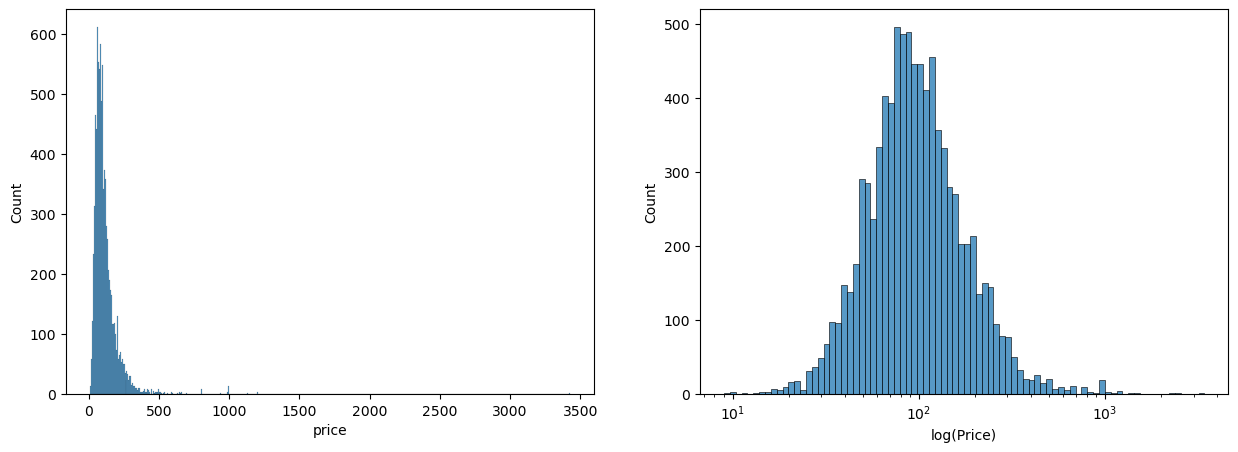

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
sns.histplot(df.price[df.price<5000])

plt.subplot(1, 2, 2)
sns.histplot(df.price[df.price<5000], log_scale=True)
plt.xlabel('log(Price)')
plt.show()

In [ ]:
[i for i in df.columns if 'estimat' in i]

['estimated_occupancy_l365d', 'estimated_revenue_l365d']

In [ ]:
df.groupby(['host_verifications'])['price'].agg(['count','mean']).round(2)

,count,mean
host_verifications,,
"['email', 'phone', 'work_email']",1151,118.75
"['email', 'phone']",7022,120.53
['email'],6,85.33
"['phone', 'work_email']",48,102.00
['phone'],640,117.15
[],4,147.25


### Amenties column: Expand to make bools of individual amenities per row in our df

In [ ]:
# %%time
# # Convert amenities to lists (using your eval approach)
# amenities = pd.Series(map(eval, df.amenities))
# print(amenities.shape)

# # Normalize text: lowercase + replace spaces with underscores
# normalized_amenities = amenities.apply(lambda lst: [i.lower().replace(' ', '_') for i in lst])
# print(normalized_amenities.shape)

# # One-hot encode
# amenities_expanded = pd.get_dummies(normalized_amenities.explode()).groupby(level=0).max()
# amenities_expanded = amenities_expanded.add_prefix('amenity_')
# print(amenities_expanded.shape)

# # Merge back
# print(df.shape)
# amenities_expanded = amenities_expanded.reindex(df.index, fill_value=0)
# df = pd.concat([df.drop(['amenities'], axis=1), amenities_expanded], axis=1)
# print(df.shape)

In [ ]:
df.dtypes['host_is_superhost']

dtype('bool')

In [ ]:
df['log_price'] = np.log(df.price)
df.price.mean(), df.log_price.mean()

remove_columns = ['id','host_name', 'amenities','host_verifications','price']

df = df.drop(remove_columns, axis=1)
df.head(2)

,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,distance_alex,distance_isle_of_museums,distance_brandenburg_gate,distance_zoo,distance_charlottenburg_castle,distance_berlin_wall,closest_station,distance_closest_station,number_of_lines,is_west_berlin,log_price
0,3718,2008-10-19,Outside Germany,within a day,67.0,40.0,False,Prenzlauer Berg,1.0,1.0,True,True,"Berlin, Germany",Prenzlauer Berg Südwest,Pankow,52.53471,13.41810,Entire rental unit,Entire home/apt,2,1.0,1.0,2.0,63,730,1.0,63.0,730.0,730.0,62.7,730.0,False,0,0,11,286,149,1,1,212,0,126,13230.0,2009-06-20,2025-03-02,4.63,4.67,4.52,4.65,4.7,4.92,4.61,False,1,1,0,0,0.78,1.539717,2.263045,3.376051,6.125432,8.434369,3.806687,Senefelderplatz,0.452641,1,False,4.653960
1,33852,2009-08-25,Berlin,a few days or more,0.0,0.0,False,Prenzlauer Berg,1.0,1.0,True,True,"Berlin, Germany",Prenzlauer Berg Südwest,Pankow,52.53269,13.41805,Entire rental unit,Entire home/apt,7,2.5,4.0,4.0,6,14,6.0,6.0,14.0,14.0,6.0,14.0,False,0,0,0,109,7,0,0,35,0,0,0.0,2015-08-09,2020-01-04,5.00,5.00,5.00,5.00,5.0,4.86,4.86,False,1,1,0,0,0.06,1.325206,2.075153,3.246219,6.016864,8.395741,3.607563,Senefelderplatz,0.377216,1,False,4.905275


In [ ]:
df.select_dtypes(include=['datetime'])

,host_since,first_review,last_review
0,2008-10-19,2009-06-20,2025-03-02
1,2009-08-25,2015-08-09,2020-01-04
2,2009-11-18,2010-06-29,2023-11-30
3,2009-12-20,2010-06-04,2017-12-14
4,2010-01-08,2010-02-18,2022-12-01
...,...,...,...
8885,2025-03-12,NaT,NaT
8886,2025-03-12,NaT,NaT
8887,2010-11-28,NaT,NaT
8888,2025-03-11,NaT,NaT


In [ ]:
categorical_features = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
categorical_features

['host_id',
 'host_location',
 'host_response_time',
 'host_is_superhost',
 'host_neighbourhood',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'property_type',
 'room_type',
 'has_availability',
 'instant_bookable',
 'closest_station',
 'is_west_berlin']

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from tabulate import tabulate

def evaluate_regression_model(model, X_train, y_train, X_test, y_test):
    # Get predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate metrics
    metrics = [
        ["RMSE",
         mean_squared_error(y_train, y_pred_train),
         mean_squared_error(y_test, y_pred_test)],
        ["R²",
         r2_score(y_train, y_pred_train),
         r2_score(y_test, y_pred_test)]
    ]

    # Print table
    print("\n->Evaluation Metrics:")
    print(tabulate(metrics,
                   headers=["Metric", "Train", "Test"],
                   floatfmt=".3f",
                   tablefmt="grid"))

0:	learn: 0.5834739	test: 0.5960857	best: 0.5960857 (0)	total: 4.21ms	remaining: 4.21s
50:	learn: 0.3271166	test: 0.3171641	best: 0.3171641 (50)	total: 201ms	remaining: 3.73s
100:	learn: 0.2834219	test: 0.2783119	best: 0.2783119 (100)	total: 381ms	remaining: 3.39s
150:	learn: 0.2603589	test: 0.2614566	best: 0.2614566 (150)	total: 571ms	remaining: 3.21s
200:	learn: 0.2446088	test: 0.2538878	best: 0.2538752 (199)	total: 759ms	remaining: 3.02s
250:	learn: 0.2336463	test: 0.2507936	best: 0.2507936 (250)	total: 948ms	remaining: 2.83s
300:	learn: 0.2252634	test: 0.2487035	best: 0.2487035 (300)	total: 1.13s	remaining: 2.63s
350:	learn: 0.2160590	test: 0.2465743	best: 0.2465743 (350)	total: 1.31s	remaining: 2.43s
400:	learn: 0.2092479	test: 0.2451352	best: 0.2450830 (399)	total: 1.51s	remaining: 2.26s
450:	learn: 0.2029791	test: 0.2445604	best: 0.2445259 (449)	total: 1.7s	remaining: 2.07s
500:	learn: 0.1973620	test: 0.2441778	best: 0.2441778 (500)	total: 1.89s	remaining: 1.88s
550:	learn: 0.19

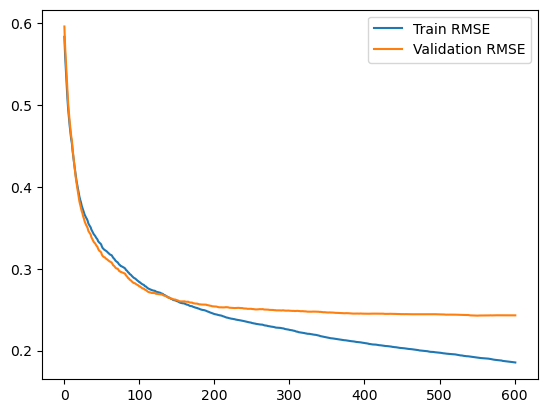

CPU times: user 15.3 s, sys: 1.58 s, total: 16.9 s
Wall time: 2.45 s


(<matplotlib.legend.Legend at 0x28079a870>, None)

In [ ]:
%%time
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

# Step 1: Prepare the features (X) and target (y)
X = df.drop(columns=['log_price'])
y = df[['log_price']]

# Categorical features
categorical_features = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Make sure these features are of object type
X = X.astype({i:str for i in categorical_features})

# Date Features:
date_cols = ['host_since', 'first_review', 'last_review']  # Replace with your date columns
for col in date_cols:
    X[col] = pd.to_datetime(X[col]).astype('int64')  # Convert to Unix timestamp

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize CatBoostRegressor with parameters and specify categorical features
model = CatBoostRegressor(
    iterations=1000,            # Number of boosting iterations
    learning_rate=0.1,         # Step size for each iteration, balances speed and accuracy
    depth=5,                   # Depth of each tree, higher depth may improve accuracy but increases overfitting risk
    loss_function='RMSE',      # Loss function to optimize, RMSE is suitable for regression tasks
    eval_metric='RMSE',        # Metric for evaluating model performance on validation set
    random_seed=42,            # Seed for reproducibility
    verbose=50,                # Frequency of training log output
)

# Step 4: Train the model on the training data
# model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=categorical_features, early_stopping_rounds=50)
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    cat_features=categorical_features,
    early_stopping_rounds=50,
    verbose=50,
    # plot=True  # Optional: Shows live R²/RMSE plot
)

# Step 5: Evaluate the model
evaluate_regression_model(model, X_train, y_train, X_test, y_test)

# Extract training/validation loss history
train_loss = model.evals_result_['learn']['RMSE']  # Training loss
val_loss = model.evals_result_['validation']['RMSE']  # Validation loss

# Plot the loss curves
plt.plot(train_loss, label='Train RMSE')
plt.plot(val_loss, label='Validation RMSE')
plt.grid(True), plt.legend(), plt.show()

In [ ]:
import pandas as pd

# Find columns with NaT values
nat_columns = df.columns[df.isna().any() & (df.apply(lambda x: pd.api.types.is_datetime64_any_dtype(x)))]

# Calculate percentage of NaT values in each column
nat_percentage = {col: (df[col].isna().mean() * 100) for col in nat_columns}

print("Columns with NaT values:", nat_columns.tolist())
print("Percentage of NaT values:", nat_percentage)

Columns with NaT values: ['host_since', 'first_review', 'last_review']
Percentage of NaT values: {'host_since': np.float64(0.21372328458942633), 'first_review': np.float64(22.992125984251967), 'last_review': np.float64(22.992125984251967)}


,feature,importance
42,estimated_revenue_l365d,20.310796
17,property_type,12.059100
41,estimated_occupancy_l365d,10.420372
21,bedrooms,8.181694
0,host_id,5.226408


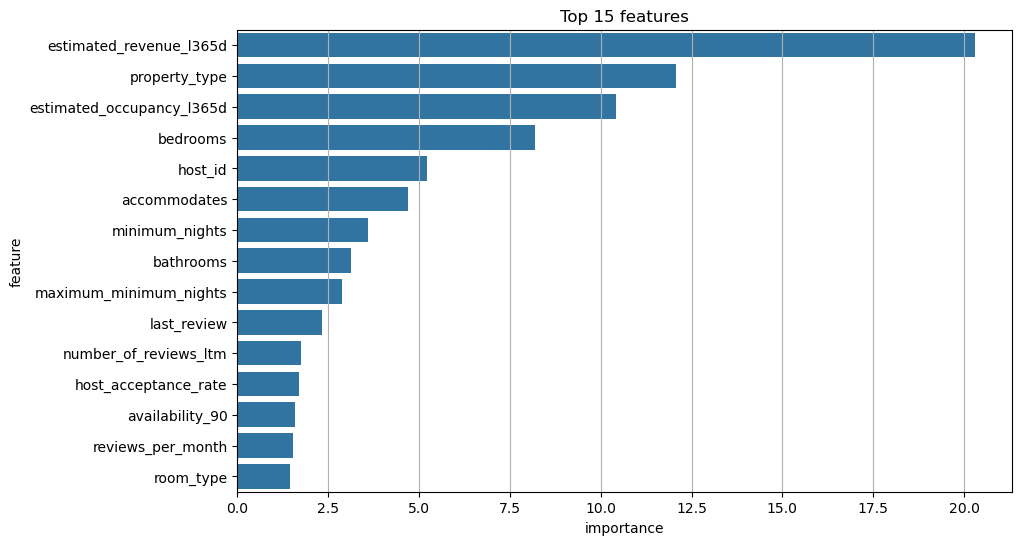

In [ ]:
# Step 6: Feature importance plot
feature_importances = pd.DataFrame({
                        'feature' : X.columns,
                        'importance' : model.get_feature_importance()
                                 })

feature_importances.sort_values('importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
plt.grid()
sns.barplot(data=feature_importances[0:15], y='feature', x='importance', orient='h').set_title("Top 15 features")

feature_importances[0:5]

# NN

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torchsummary
import torchvision

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
with open('/content/drive/MyDrive/Colab Notebooks/data/cleaned_listing_data.pkl', 'rb') as f:
    df = pickle.load(f).reset_index(drop=True)

print(df.shape)
df

(8890, 73)


,id,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,...,distance_alex,distance_isle_of_museums,distance_brandenburg_gate,distance_zoo,distance_charlottenburg_castle,distance_berlin_wall,closest_station,distance_closest_station,number_of_lines,is_west_berlin
0,3176,3718,Britta,2008-10-19,Outside Germany,within a day,67.0,40.0,False,Prenzlauer Berg,...,1.539717,2.263045,3.376051,6.125432,8.434369,3.806687,Senefelderplatz,0.452641,1,False
1,9991,33852,Philipp,2009-08-25,Berlin,a few days or more,0.0,0.0,False,Prenzlauer Berg,...,1.325206,2.075153,3.246219,6.016864,8.395741,3.607563,Senefelderplatz,0.377216,1,False
2,14325,55531,Chris + Oliver,2009-11-18,Berlin,within a few hours,100.0,38.0,True,Prenzlauer Berg,...,3.013079,3.408976,3.893683,6.249913,7.894639,5.582943,Schönhauser Allee,0.777859,2,False
3,16644,64696,Rene,2009-12-20,Outside Germany,None,NaN,0.0,False,Kreuzberg,...,2.596106,2.865028,4.175790,6.536968,9.691065,0.523791,Schlesisches Tor,0.514633,2,True
4,17904,68997,Matthias,2010-01-08,Outside Germany,within an hour,100.0,95.0,False,Copacabana,...,3.113997,2.983439,3.901180,5.811598,9.089765,1.793758,Schönleinstraße,0.127654,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8885,1376348748790549852,683964744,Martin Ewald,2025-03-12,None,None,NaN,NaN,False,None,...,4.079075,3.196148,1.982368,1.500576,4.820771,5.640749,Kurfürstenstraße,0.365918,2,True
8886,1376356410353693375,683964744,Martin Ewald,2025-03-12,None,None,NaN,NaN,False,None,...,4.203290,3.321344,2.142934,1.535790,4.860014,5.688689,Kurfürstenstraße,0.255885,2,True
8887,1376569769868596901,302404,Mario,2010-11-28,Berlin,within a day,84.0,23.0,False,None,...,3.165369,2.649456,3.012005,4.487625,7.799308,3.052087,Gneisenaustraße,0.421697,1,True
8888,1376576995944779676,683688233,Konrad,2025-03-11,None,None,NaN,100.0,False,None,...,16.907618,17.037468,17.980453,19.244019,22.510798,14.092149,Rudow,4.733977,1,False


In [4]:
# log transform price and store in y
y = np.log(df.price).values

# Remove useless columns
remove_columns = ['id','host_name', 'amenities','host_verifications','price','host_since', 'first_review', 'last_review']
X = df.drop(columns = remove_columns)
X.head(2)

,host_id,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,...,distance_alex,distance_isle_of_museums,distance_brandenburg_gate,distance_zoo,distance_charlottenburg_castle,distance_berlin_wall,closest_station,distance_closest_station,number_of_lines,is_west_berlin
0,3718,Outside Germany,within a day,67.0,40.0,False,Prenzlauer Berg,1.0,1.0,True,...,1.539717,2.263045,3.376051,6.125432,8.434369,3.806687,Senefelderplatz,0.452641,1,False
1,33852,Berlin,a few days or more,0.0,0.0,False,Prenzlauer Berg,1.0,1.0,True,...,1.325206,2.075153,3.246219,6.016864,8.395741,3.607563,Senefelderplatz,0.377216,1,False


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8890 entries, 0 to 8889
Data columns (total 65 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_id                                       8890 non-null   object 
 1   host_location                                 6855 non-null   object 
 2   host_response_time                            7644 non-null   object 
 3   host_response_rate                            7644 non-null   float64
 4   host_acceptance_rate                          7936 non-null   float64
 5   host_is_superhost                             8890 non-null   bool   
 6   host_neighbourhood                            3226 non-null   object 
 7   host_listings_count                           8871 non-null   float64
 8   host_total_listings_count                     8871 non-null   float64
 9   host_has_profile_pic                          8890 non-null   b

In [6]:
# Identify feature types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()

# Train-test split (before preprocessing to avoid data leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create preprocessing pipeline
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numeric_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
#     ])

# # Fit on train, transform both train and test
# X_train_processed = preprocessor.fit_transform(X_train)
# X_test_processed = preprocessor.transform(X_test)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Numeric columns: Fill NaNs with median (avoid mean due to outliers)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handles NaN
    ('scaler', StandardScaler())
])

# Categorical columns: Fill NaNs with 'missing' and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),  # Handles NaN/None
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit/transform (as before)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [8]:
# display at first 2 rows of X_train_processed


In [9]:
# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_processed.toarray())
X_test_tensor = torch.FloatTensor(X_test_processed.toarray())
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

In [10]:
# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# from tqdm import trange

# num_epochs = 20
# master_bar = trange(num_epochs, desc="Progress")

# for epoch in master_bar:
#   train_loss, train_acc = train(train_dataloader, optimizer, model, loss_function, device, None)
#   val_loss, val_acc = validate(val_dataloader, model, loss_function, device, None)

#   master_bar.write(f' - EPOCH: {epoch+1} -- TrainLoss: {train_loss:.2f} -- ValLoss: {val_loss:.2f} -- TrainAcc: {train_acc:.2f} -- ValAcc: {val_acc:.2f}')

#   # Early stopper logic
#   N, tol = 5, 0.001
#   if epoch >= N and (val_losses[-N] - val_loss <= tol):
#     master_bar.write(f"--Stopped due to early stopper logic! --- {val_losses[-N]:.3f} - {val_loss:.3f} <= {tol}")
#     break




In [46]:
from tqdm import trange

def train_model(model, train_loader, test_loader, criterion, optimizer, n_epochs, device):

    master_bar = trange(n_epochs, desc="Progress")
    model.to(device)
    history = {'train_loss': [], 'test_loss': []}

    for epoch in master_bar:
        # Training (FP and BP)
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch) ## These are y_pred. Keeping it like this for classification models where these are distributions of softmax
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)

        epoch_train_loss = train_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)

        # Evaluation
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                test_loss += criterion(outputs, y_batch).item() * X_batch.size(0)

        epoch_test_loss = test_loss / len(test_loader.dataset)
        history['test_loss'].append(epoch_test_loss)

        master_bar.write(f' Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f}')

        # Early stopper logic
        N, tol = 5, 0.005
        if epoch >= N and (history['test_loss'][-N] - epoch_test_loss <= tol):
          master_bar.write(f"-->Stopped due to EarlyStopperLogic (N={N}, tol={tol}) | {history['test_loss'][-N]:.4f} - {epoch_test_loss:.4f} <= {tol}")
          break

    return model, history

In [47]:
abs(-1)

1

In [48]:
X.shape

(8890, 65)

In [106]:
# Define neural network model: Fully connected with 3 hidden layers
class MLP(nn.Module):

  def __init__(self, input_dim, output_dim):
    super(MLP, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.layers = nn.Sequential(
        #layer 1
        nn.Linear(input_dim, 512),
        nn.ReLU(),
        #layer 2
        nn.Linear(512, 256),
        nn.ReLU(),
        #layer 3
        nn.Linear(256, 128),
        nn.ReLU(),
        #output layer
        nn.Linear(128, output_dim)
        )

  def forward(self, x):
    # x = torch.flatten(x, 1)
    outputs = self.layers(x)
    return outputs

In [107]:
# print torch summary for above model
model2 = MLP(5005, 1).cpu()
torchsummary.summary(model2, (5005,), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       2,563,072
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 256]         131,328
              ReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
              ReLU-6                  [-1, 128]               0
            Linear-7                    [-1, 1]             129
Total params: 2,727,425
Trainable params: 2,727,425
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.01
Params size (MB): 10.40
Estimated Total Size (MB): 10.44
----------------------------------------------------------------


In [100]:
model = MLP(5005, 1)

X_batch, y_batch = next(iter(train_loader))
X_batch.shape, y_batch.shape

outputs = model(X_batch)
print(outputs.shape)
outputs[0:5]

torch.Size([256, 1])


tensor([[-0.0613],
        [-0.0541],
        [-0.0568],
        [-0.0599],
        [-0.0568]], grad_fn=<SliceBackward0>)

In [109]:
# Initialize model, loss and optimizer
input_dim = X_train_processed.shape[1]
output_dim = 1

model = MLP(input_dim, output_dim)
print("input size:", input_dim)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

input size: 5005
cuda


In [110]:
# Train NN
model, history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=50,
    device=DEVICE
)

Progress:   2%|▏         | 1/50 [00:00<00:10,  4.75it/s]

 Train Loss: 13.8576 | Test Loss: 2.4786


Progress:   4%|▍         | 2/50 [00:00<00:09,  4.84it/s]

 Train Loss: 0.9760 | Test Loss: 0.3558


Progress:   6%|▌         | 3/50 [00:00<00:09,  4.73it/s]

 Train Loss: 0.2001 | Test Loss: 0.1802
 Train Loss: 0.0925 | Test Loss: 0.1481


Progress:  12%|█▏        | 6/50 [00:01<00:08,  4.94it/s]

 Train Loss: 0.0545 | Test Loss: 0.1251
 Train Loss: 0.0355 | Test Loss: 0.1238


Progress:  14%|█▍        | 7/50 [00:01<00:08,  4.98it/s]

 Train Loss: 0.0253 | Test Loss: 0.1135


Progress:  18%|█▊        | 9/50 [00:01<00:08,  4.98it/s]

 Train Loss: 0.0198 | Test Loss: 0.1173
 Train Loss: 0.0157 | Test Loss: 0.1105


Progress:  20%|██        | 10/50 [00:02<00:08,  4.97it/s]

 Train Loss: 0.0139 | Test Loss: 0.1089
 Train Loss: 0.0127 | Test Loss: 0.1101


Progress:  20%|██        | 10/50 [00:02<00:08,  4.47it/s]

-->Stopped due to EarlyStopperLogic (N=5, tol=0.005) | 0.1135 - 0.1101 <= 0.005


In [111]:
pd.DataFrame(history)

,train_loss,test_loss
0,13.857607,2.478606
1,0.975957,0.355791
2,0.200096,0.180151
3,0.092504,0.148131
4,0.054513,0.125118
5,0.035542,0.123800
6,0.025350,0.113507
7,0.019763,0.117262
8,0.015651,0.110482
9,0.013879,0.108914


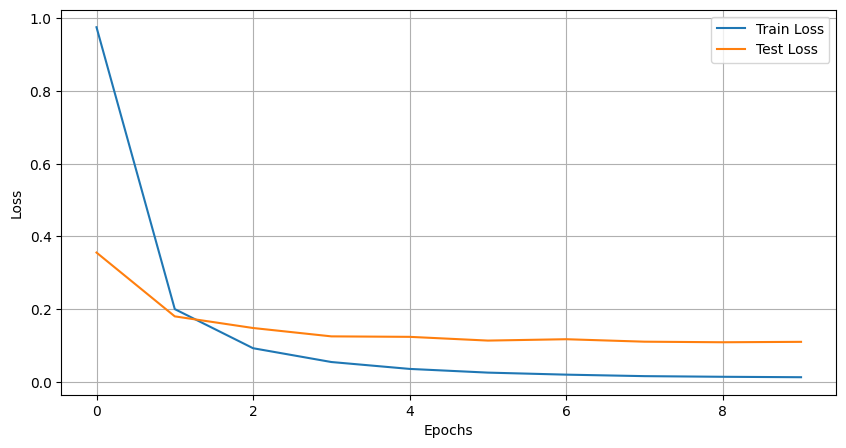

In [112]:
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'][1:], label='Train Loss')
plt.plot(history['test_loss'][1:], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [113]:
from sklearn.metrics import mean_squared_error, r2_score
from tabulate import tabulate

model = model.to('cpu')
# Get predictions
with torch.no_grad():
    # Get predictions and convert to numpy
    y_pred_train = model(X_train_tensor).numpy()
    y_pred_test = model(X_test_tensor).numpy()

# Calculate metrics
metrics = [
    ["RMSE",
      mean_squared_error(y_train, y_pred_train),
      mean_squared_error(y_test, y_pred_test)],
    ["R²",
      r2_score(y_train, y_pred_train),
      r2_score(y_test, y_pred_test)]
]

# Print table
print("\n->Evaluation Metrics:")
print(tabulate(metrics,
                headers=["Metric", "Train", "Test"],
                floatfmt=".3f",
                tablefmt="grid"))


->Evaluation Metrics:
+----------+---------+--------+
| Metric   |   Train |   Test |
+==========+=========+========+
| RMSE     |   0.009 |  0.110 |
+----------+---------+--------+
| R²       |   0.974 |  0.713 |
+----------+---------+--------+
